In [2]:
'''data'''
import pandas as pd
import numpy as np
from datetime import datetime
import math


'''plotting'''
import matplotlib.pyplot as plt
from matplotlib import rc, font_manager
import seaborn as sns

'''sys library'''
#plt.style.use('fivethirtyeight')
import warnings
import os
import gc
warnings.filterwarnings('ignore')
%matplotlib inline
rc('font',family="NanumSquareR")

'''modeling'''
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
#from ggplot import *
from sklearn.linear_model import LinearRegression
import scipy.stats as st
import lightgbm as lgb
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from scipy.stats import uniform, randint
from sklearn.datasets import load_breast_cancer, load_diabetes, load_wine
from sklearn.metrics import auc, accuracy_score, confusion_matrix, mean_squared_error, f1_score, roc_auc_score
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, RandomizedSearchCV, train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_squared_log_error
#-*- coding: utf-8 -*-

'''plot theme'''
plt.style.use('ggplot') #ggplot스타일 사용
plt.rc('axes', unicode_minus=False)
rc('font', family='AppleGothic')

In [3]:
jeju_df = pd.read_csv('jeju_data_ver1/201901-202003.csv')

# ***Data Cleansing***

In [5]:
def data_wrangling(jeju_df):
    year_ls = []
    for i in jeju_df['REG_YYMM'].tolist():
        year_ls.append(int(str(i)[:4]))

    month_ls = []
    for i in jeju_df['REG_YYMM'].tolist():
        month_ls.append(int(str(i)[4:]))

    jeju_df['year'] = year_ls
    jeju_df['month'] = month_ls

    jeju_df.drop(columns = 'REG_YYMM',inplace = True)

    df = jeju_df.drop(columns = ['CARD_CCG_NM','HOM_CCG_NM'])

    columns = ['CARD_SIDO_NM', 'STD_CLSS_NM', 'HOM_SIDO_NM', 'AGE', 'SEX_CTGO_CD', 'FLC', 'year', 'month']
    df2 = df.groupby(columns).sum().reset_index(drop=False)

    # 인코딩
    dtypes = df2.dtypes
    encoders = {}
    for column in df2.columns:
        if str(dtypes[column]) == 'object':
            encoder = LabelEncoder()
            encoder.fit(df2[column])
            encoders[column] = encoder

    for column in encoders.keys():
        encoder = encoders[column]
        df2[column] = encoder.transform(df2[column])
        
    return encoder, df2

In [6]:
encoder_real, df2_real = data_wrangling(jeju_df)

# ***EDA***

### ***목표 변수 로그화  / 지수화***

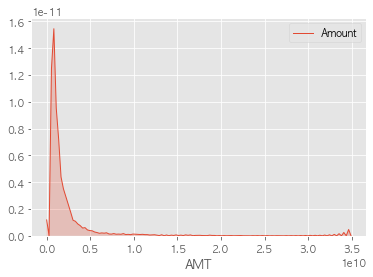

In [8]:
# Before logarism 
sns.distplot(df2_real['AMT'], hist = False, kde = True,
                         kde_kws = {'shade': True, 'linewidth': 1}, label = 'Amount')
       

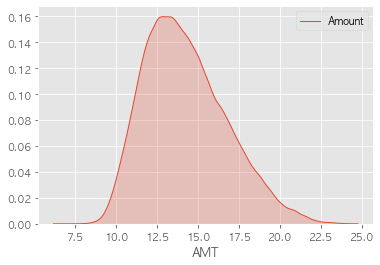

In [9]:
# After logarism
target = np.log1p(df2_real['AMT'])


sns.distplot(target, hist = False, kde = True,
                         kde_kws = {'shade': True, 'linewidth': 1}, label = 'Amount')

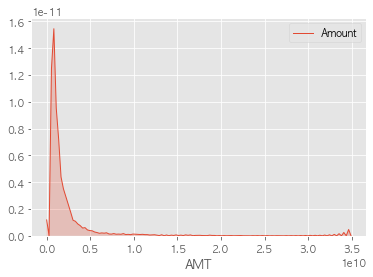

In [10]:
# After expernential
sns.distplot(np.exp(target), hist = False, kde = True,
                         kde_kws = {'shade': True, 'linewidth': 1}, label = 'Amount')

### ***월별 다음달의 카드사용 총액과의 상관관계***

In [11]:
df2_real['next_year'] = df2_real.apply(lambda x: x['year'] if x['month'] < 12 else x['year'] + 1, axis = 1)
df2_real['next_month'] = df2_real.apply(lambda x: x['month'] + 1 if x['month'] < 12 else 1, axis = 1)

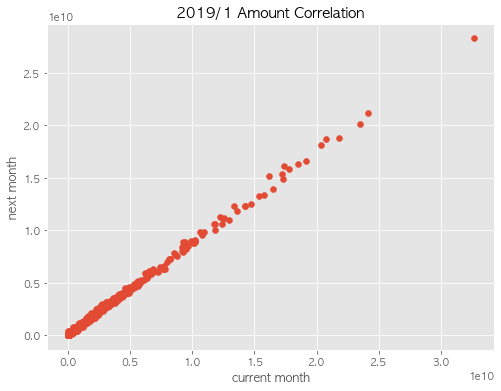

correlation :  0.9991779143122312


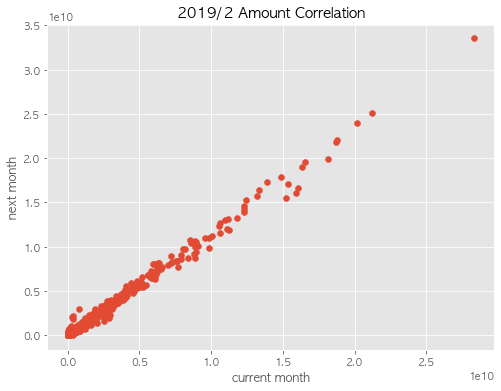

correlation :  0.997005580352788


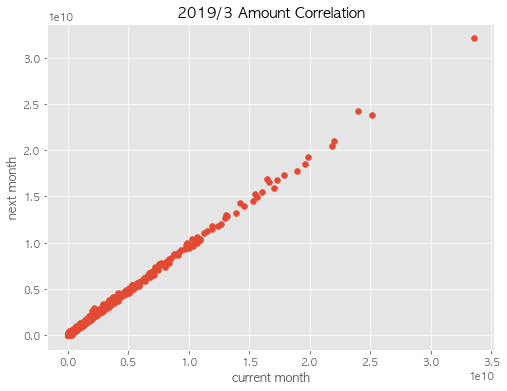

correlation :  0.9993578509577178


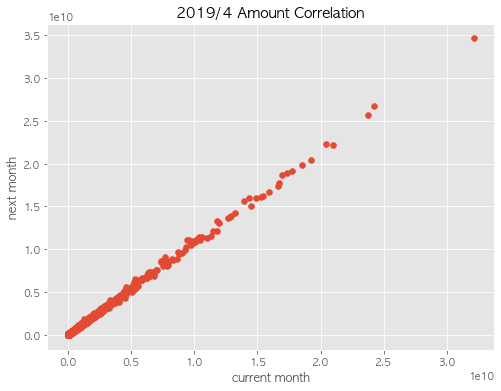

correlation :  0.9994342658791188


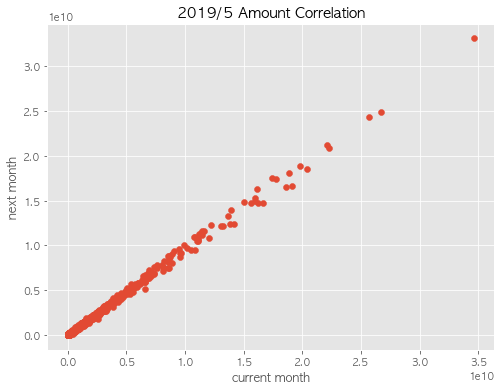

correlation :  0.998845143350388


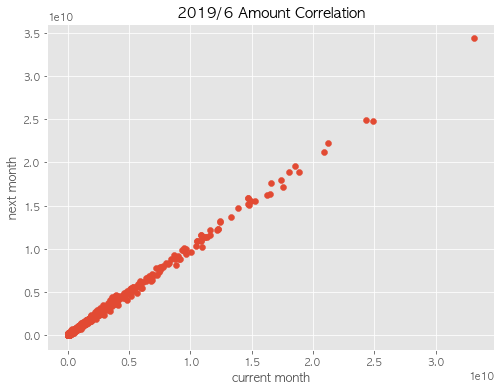

correlation :  0.9990624561001519


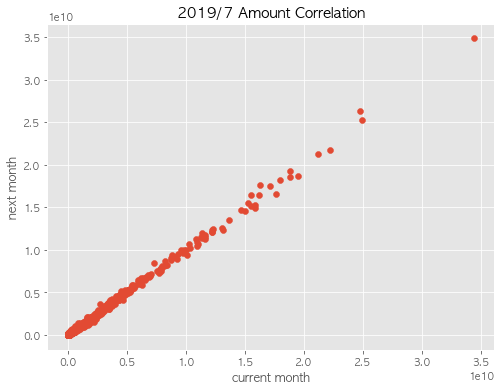

correlation :  0.9989293994813478


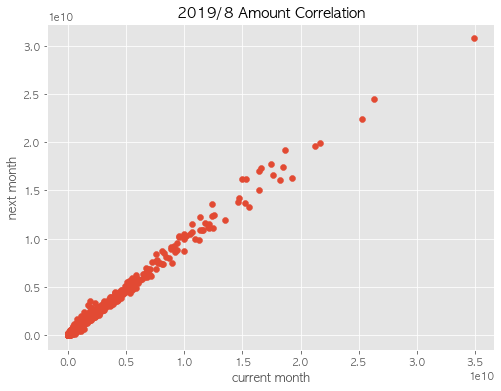

correlation :  0.996442616264839


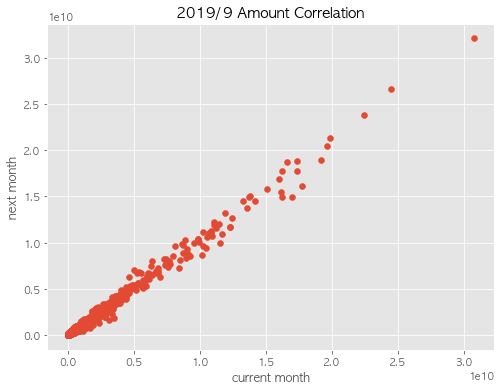

correlation :  0.9962777535759088


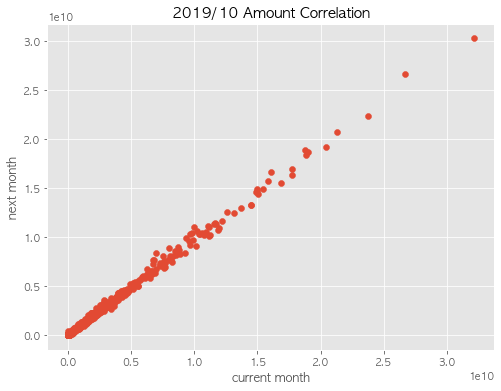

correlation :  0.9986555797207423


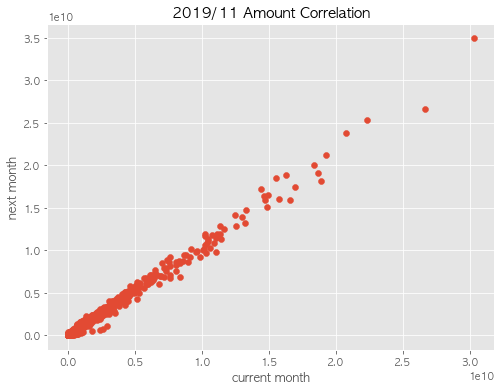

correlation :  0.9962535955012286


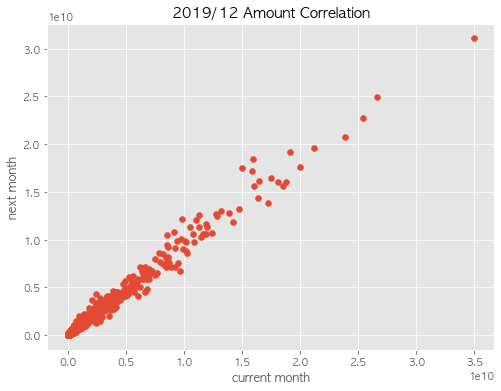

correlation :  0.9933613818475878


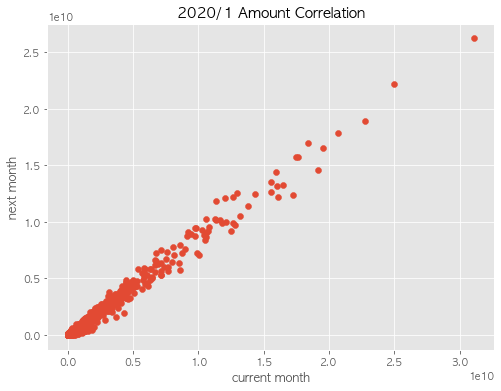

correlation :  0.9941907856888152


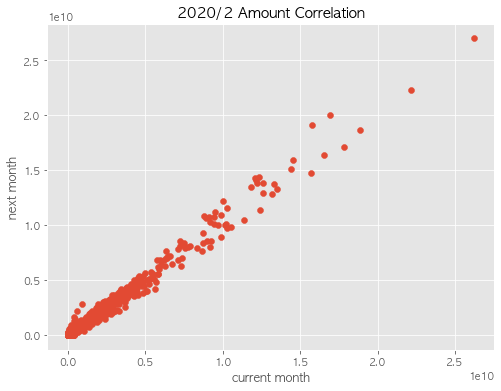

correlation :  0.9937881629466037


In [13]:
for year in [2019,2020]:
    
    for month in list(range(1,13)):
        
        if year == 2020 and month ==3:
            break
        else:
            df2_next = df2_real[(df2_real['month'] == month) & (df2_real['year'] == year)]

            df2_next2 = pd.merge(df2_next, df2_real, left_on = pd.Series(list(set(df2_real.columns) - set(['AMT','CNT','CSTMR_CNT','month','year']))).sort_values().tolist(),\
                            right_on = pd.Series(list(set(df2_real.columns) - set(['AMT','CNT','CSTMR_CNT','next_month','next_year']))).sort_values().tolist(),\
                            how = 'left')
            
            
            plt.figure(figsize = (8,6))
            plt.scatter(df2_next2['AMT_x'],df2_next2['AMT_y'])
            plt.xlabel('current month')
            plt.ylabel('next month')
            plt.title(str(year) + '/' + str(month) + ' Amount Correlation')
            plt.show()
        
            cor = df2_next2[['AMT_x','AMT_y']].corr()
            print('correlation : ', cor.iloc[0,1])

### ***월별 카드 사용량 패턴***

In [19]:
def monthly_explaination_variable_pattern(df,variable,col_valid = True):
    if col_valid == False:
    
        group_df = df.groupby(['year','month'])['AMT'].sum().reset_index(name ='AMT')
        
        ymd_ls = []

        for i in range(len(group_df)):
            y = group_df['year'].iloc[i]
            m = group_df['month'].iloc[i]

            ymd_ls.append(str(y)+'_'+str(m))
            
        plt.figure(figsize = (8,6))
        plt.bar(ymd_ls,group_df['AMT'])
        plt.xticks(rotation = 45)
        plt.title('Total' + ' Monthly AMT Pattern')
        plt.show()
        
    elif col_valid == True:
        df_test = df
        
        df_var_list = df_test[variable].unique().tolist()

        ymd_ls = []

        for var in [df_var_list[0]]:
            df_if = df_test[df_test[variable]==var]

            group_df = df_if.groupby(['year','month'])['AMT'].sum().reset_index(name ='AMT')

            for i in range(len(group_df)):
                y = group_df['year'].iloc[i]
                m = group_df['month'].iloc[i]

                ymd_ls.append(str(y)+'_'+str(m))

        pos = np.arange(len(ymd_ls))


        first = 0

        while True:

            if first < len(df_var_list):
                var_real = df_var_list[first: first + 5]

                first += 5

                plt.figure(figsize = (15,12))
                bar_width = 0.15


                for var in var_real:
                    df_if = df_test[df_test[variable]==var]

                    group_df = df_if.groupby(['year','month'])['AMT'].sum().reset_index(name ='AMT')

                    plt.bar(pos,group_df['AMT'],bar_width,edgecolor = 'black')
                    pos = pos+bar_width

                plt.xticks(pos,ymd_ls,rotation = 45)
                plt.title(variable  + ' Monthly AMT Pattern')
                plt.legend(var_real,loc=1)
                plt.show()
            else:
                break

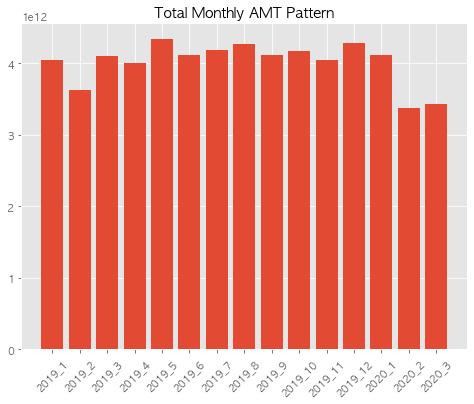

In [16]:
#전체 통으로
monthly_explaination_variable_pattern(jeju_df,'x',False)

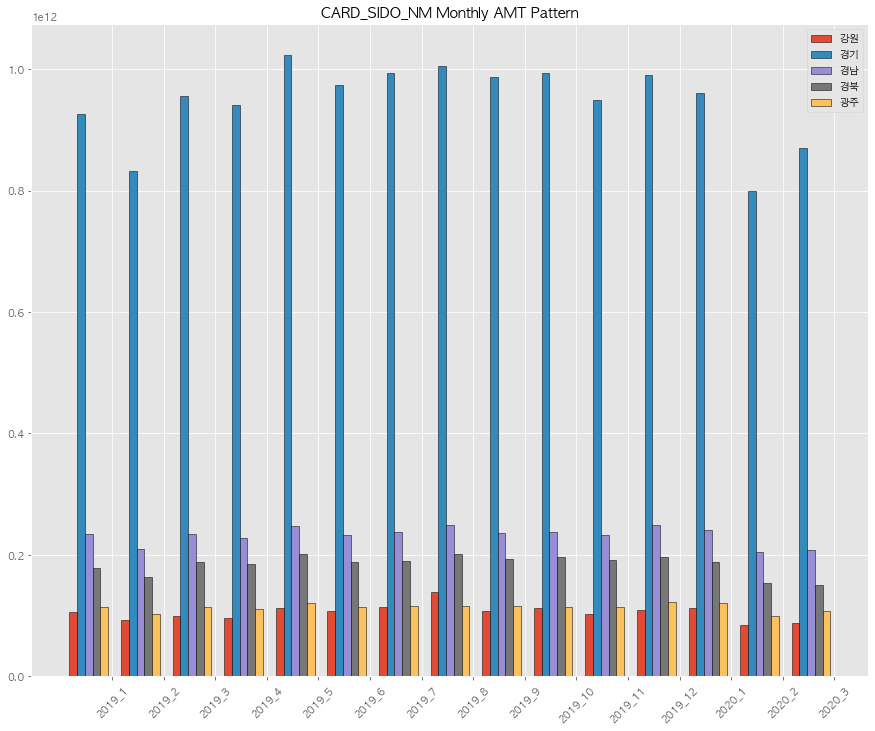

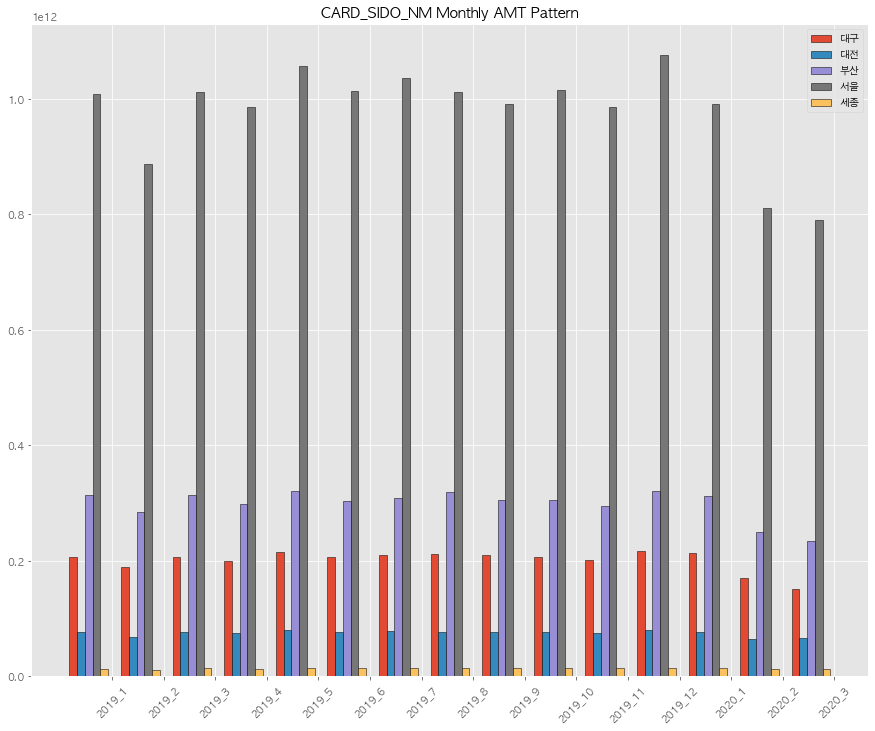

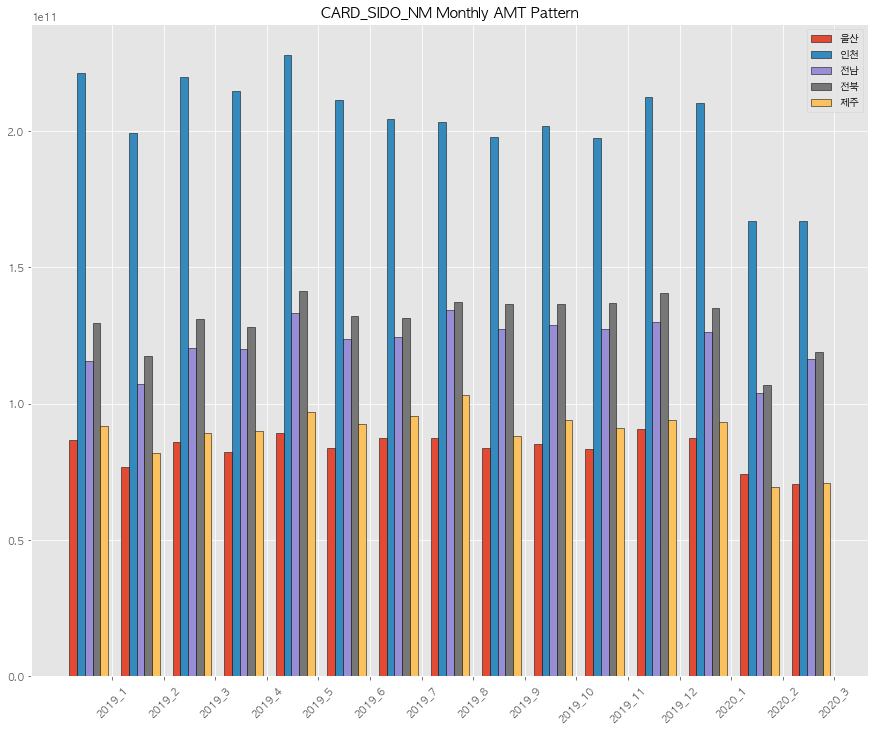

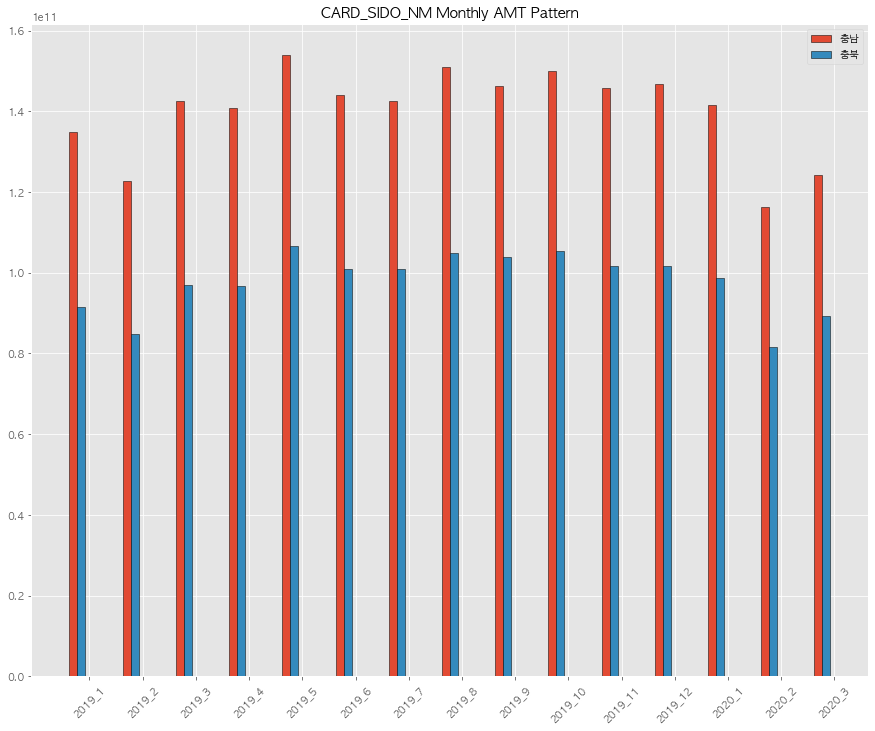

In [20]:
# 지역별
monthly_explaination_variable_pattern(jeju_df,'CARD_SIDO_NM')

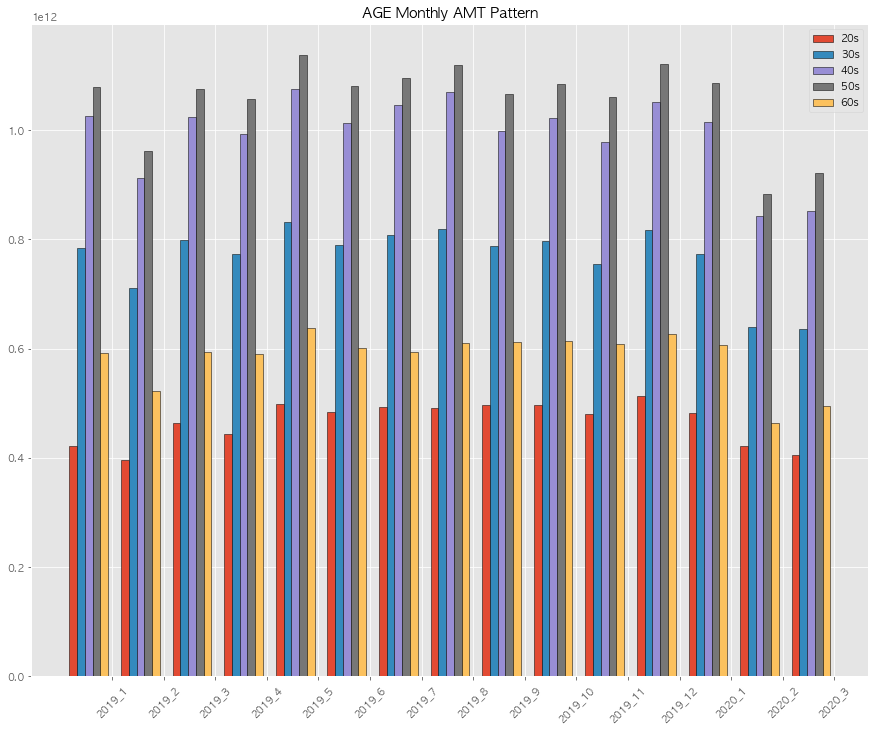

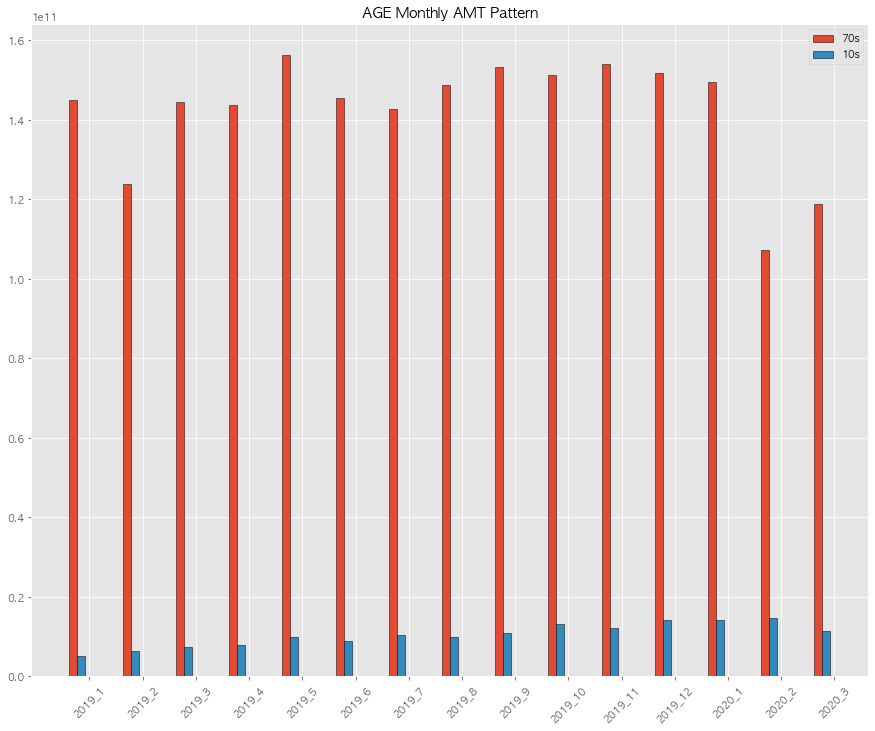

In [21]:
#연령대별
monthly_explaination_variable_pattern(jeju_df,'AGE')

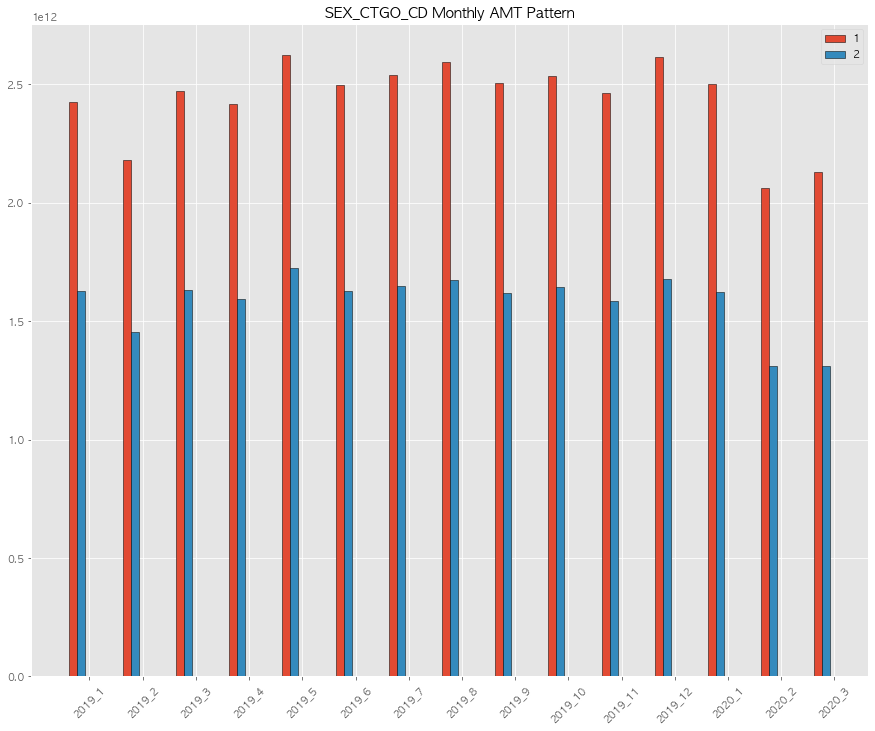

In [22]:
#성별
monthly_explaination_variable_pattern(jeju_df,'SEX_CTGO_CD')

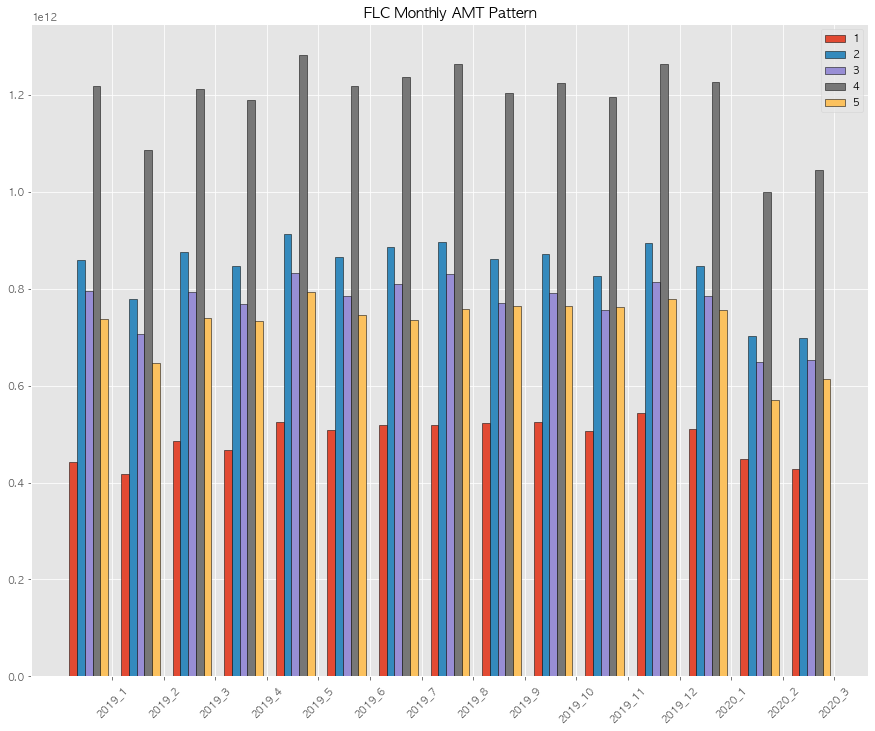

In [23]:
# 거주 분포별
monthly_explaination_variable_pattern(jeju_df,'FLC')

### ***업종별 상관관계***
    - 업종별 묶어서 확인
        - 

In [24]:
jeju_df['STD_CLSS_NM'].unique()

array(['건강보조식품 소매업', '골프장 운영업', '과실 및 채소 소매업', '관광 민예품 및 선물용품 소매업',
       '그외 기타 스포츠시설 운영업', '그외 기타 종합 소매업', '기타 대형 종합 소매업', '기타 외국식 음식점업',
       '기타 주점업', '기타음식료품위주종합소매업', '마사지업', '비알콜 음료점업', '빵 및 과자류 소매업',
       '서양식 음식점업', '수산물 소매업', '슈퍼마켓', '스포츠 및 레크레이션 용품 임대업', '여관업', '욕탕업',
       '육류 소매업', '일반유흥 주점업', '일식 음식점업', '전시 및 행사 대행업', '중식 음식점업',
       '차량용 가스 충전업', '차량용 주유소 운영업', '체인화 편의점', '피자 햄버거 샌드위치 및 유사 음식점업',
       '한식 음식점업', '호텔업', '화장품 및 방향제 소매업', '휴양콘도 운영업', '여행사업', '자동차 임대업',
       '면세점', '버스 운송업', '택시 운송업', '기타 수상오락 서비스업', '내항 여객 운송업',
       '그외 기타 분류안된 오락관련 서비스업', '정기 항공 운송업'], dtype=object)